In [1]:
import h5py
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import mode

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from hbtp import HBTReader
from src import read

In [2]:
plt.style.use('paper')

In [3]:
snap = 51
grav = "GR_b64n512"
nbins = 20
reader = HBTReader("./data/%s/subcat/" % grav)
haloes = reader.LoadHostHalos(snap)
haloes = haloes[read.ids(grav, snap)]

In [4]:
bin = 5

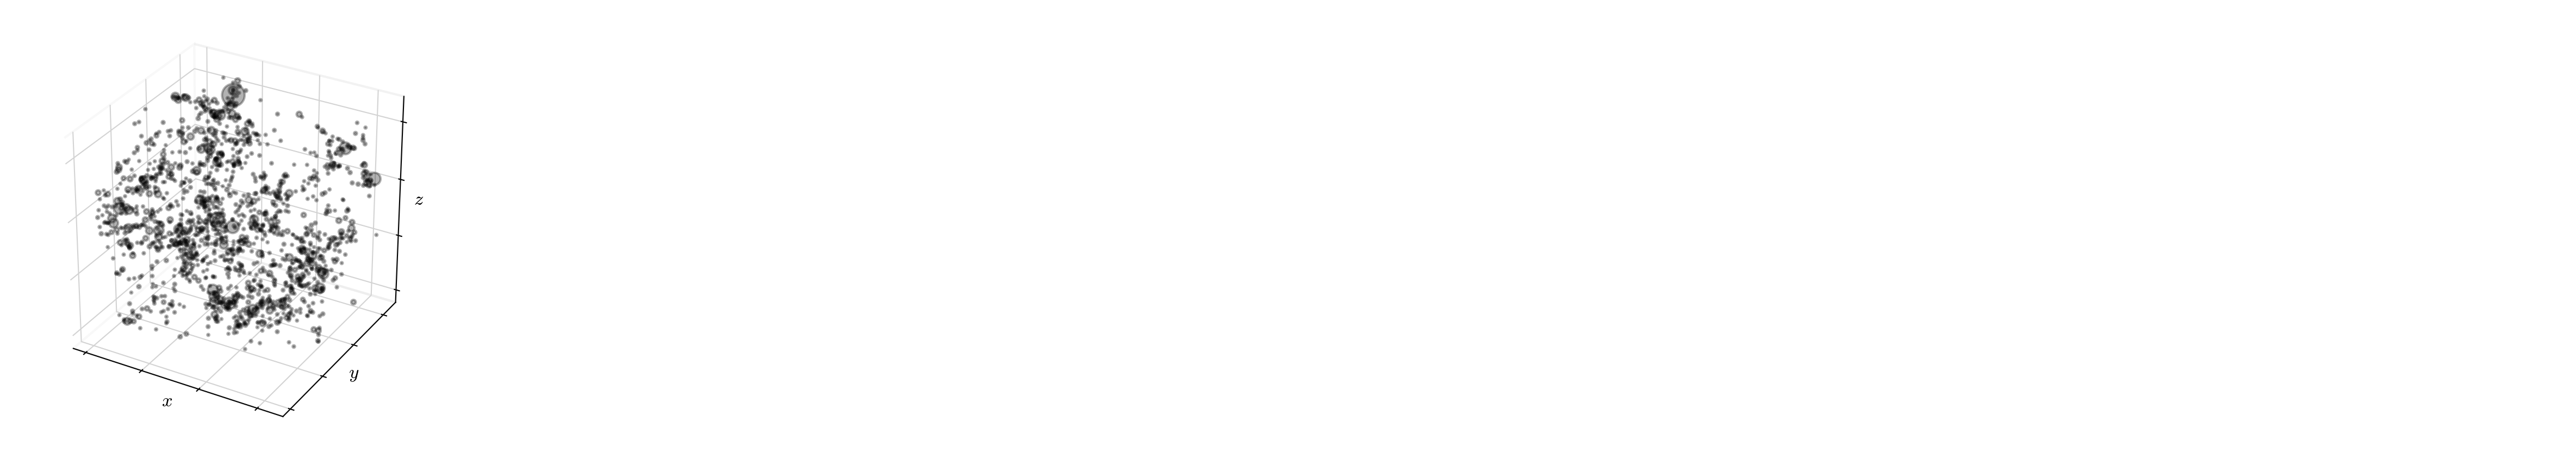

In [5]:
fig, ax = plt.subplots(1, subplot_kw={'projection': '3d'})
ax.set_xlabel(r"$x$", labelpad=-15)
ax.set_ylabel(r"$y$", labelpad=-15)
ax.set_zlabel(r"$z$", labelpad=-15)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# fig.suptitle("%d haloes at snapshot %d" % (len(haloes), snap))

ax.scatter(
    *haloes['CenterComoving'].T,
    s=100*(haloes['M200Crit'] / haloes['M200Crit'].max()),
    c='k',
    alpha=0.3,
)

## Implementation of Haas 2011 environment definition

In [6]:
def nearest_neighbour_old(halo, f=1.0, N=0):
    """Nearest neighbour more massive then f*M.
    """

    _haloes = haloes[
        (haloes["HaloId"] != halo["HaloId"]) &
        (haloes["M200Crit"] >= 1.0 * halo["M200Crit"])
    ]

    if len(_haloes) < 1:
        d = np.inf

    else:
        
        d = (
            np.sort(
                np.sqrt(
                    np.sum(
                        np.power(
                            halo["CenterComoving"]
                            - _haloes["CenterComoving"],
                            2.0,
                        ),
                        axis=1,
                    )
                )
            )[N]
            / halo["R200CritComoving"]
        )

    return d

In [7]:
def nearest_neighbour(halo, f=1.0):
    """Nearest neighbour more massive then f*M.
    """

    _haloes = haloes[
        (haloes["HaloId"] != halo["HaloId"]) &
        (haloes["M200Crit"] >= 1.0 * halo["M200Crit"])
    ]

    if len(_haloes) < 1:
        d = np.inf

    else:
        _neighbour = _haloes[_haloes['M200Crit'].argmin()]

        d = np.linalg.norm(
            _neighbour['CenterComoving'] - 
            halo['CenterComoving']
#         ) / halo['R200CritComoving']
        ) / _neighbour['R200CritComoving']

    return d

100%|██████████| 1577/1577 [00:00<00:00, 17674.83it/s]
/cosma/home/dp004/dc-oles1/var/cosma7/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in subtract
  This is separate from the ipykernel package so we can avoid doing imports until


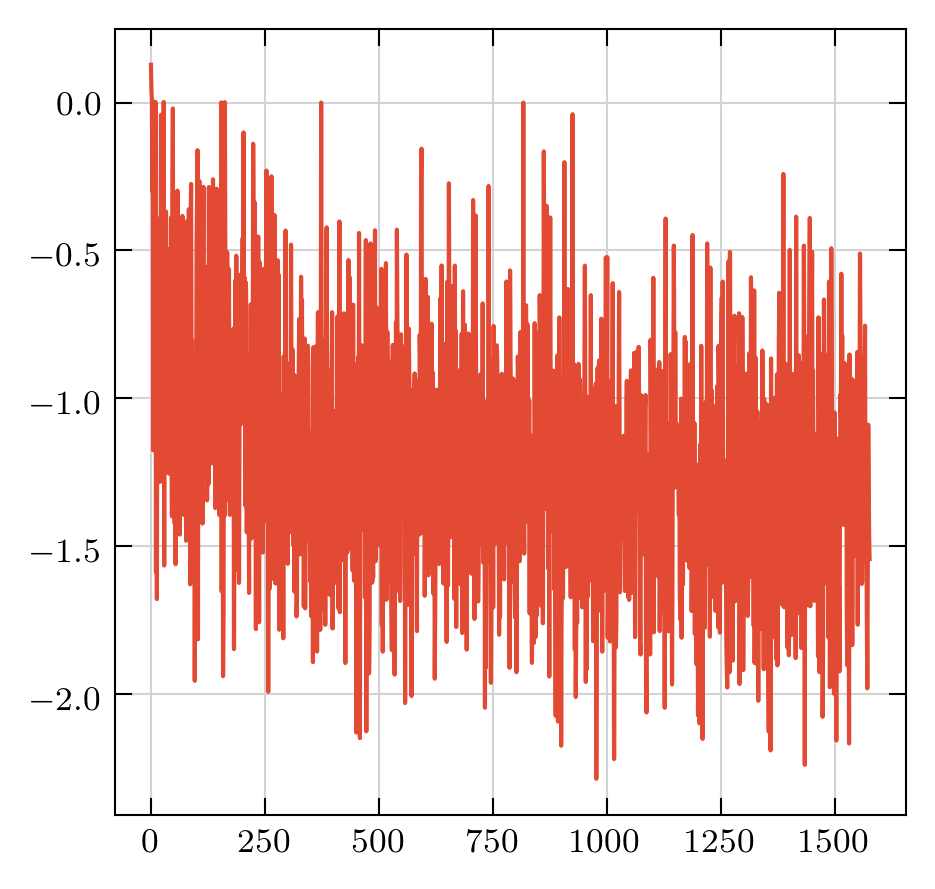

In [8]:
plt.plot(
    np.log10([nearest_neighbour_old(halo) for halo in tqdm(haloes)]) -
    np.log10([nearest_neighbour(halo) for halo in tqdm(haloes)])
)

## Other metrics (see Shi+2017)

Not implemented.

In [9]:
def spherical_overdensity(halo, r=5):
    """(Over)density within radius ``r`` of halo center.
    """
    return 0.0

def shell_overdensity(halo, r_min=1, r=5):
    """(Over)density within shell between ``r_min`` and ``r``.
    """
    return 0.0

def experienced_potential(halo):
    """Experienced gravity for a halo.
    """
    c = halo['NFW_c']
    r_s = nfw.r_s(c)
    delta_c = nfw.delta_c(c)

    rs = np.linspace(-2.0, 0.0, 100)
    phi = [phi(r) for r in rs]

    phi_star = phi + 4*np.pi*G*delta_c * cosmology.rho_crit(halo['snap']) * \
        np.div((r_s * r_s * r_s), rs) * np.log(1.0 + rs / r_s)

    return np.mean(phi_star)

In [10]:
dnf = np.log10([nearest_neighbour(halo) for halo in tqdm(haloes)])

100%|██████████| 1577/1577 [00:00<00:00, 16197.99it/s]


In [11]:
def plot3d(xs, ys, zs, ss, cs):
    ix = ~np.isinf(cs)
    xs, ys, zs, ss, cs = xs[ix], ys[ix], zs[ix], ss[ix], cs[ix]

    scalarMap = matplotlib.cm.ScalarMappable(
        norm=matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs)),
        cmap=plt.get_cmap('viridis')
    )
    scalarMap.set_array(cs)
    fig, ax = plt.subplots(1, subplot_kw={'projection': '3d'})
    ax.set_xlabel(r"$x$", labelpad=-15)
    ax.set_ylabel(r"$y$", labelpad=-15)
    ax.set_zlabel(r"$z$", labelpad=-15)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    fig.colorbar(scalarMap).ax.set_ylabel(r"$\log_{10}(D_{N,f})$", rotation=270, labelpad=10)
    ax.scatter(xs, ys, zs, s=20*((ss-np.min(ss))/np.max(ss))+1, c=scalarMap.to_rgba(cs))
    
    return fig, ax

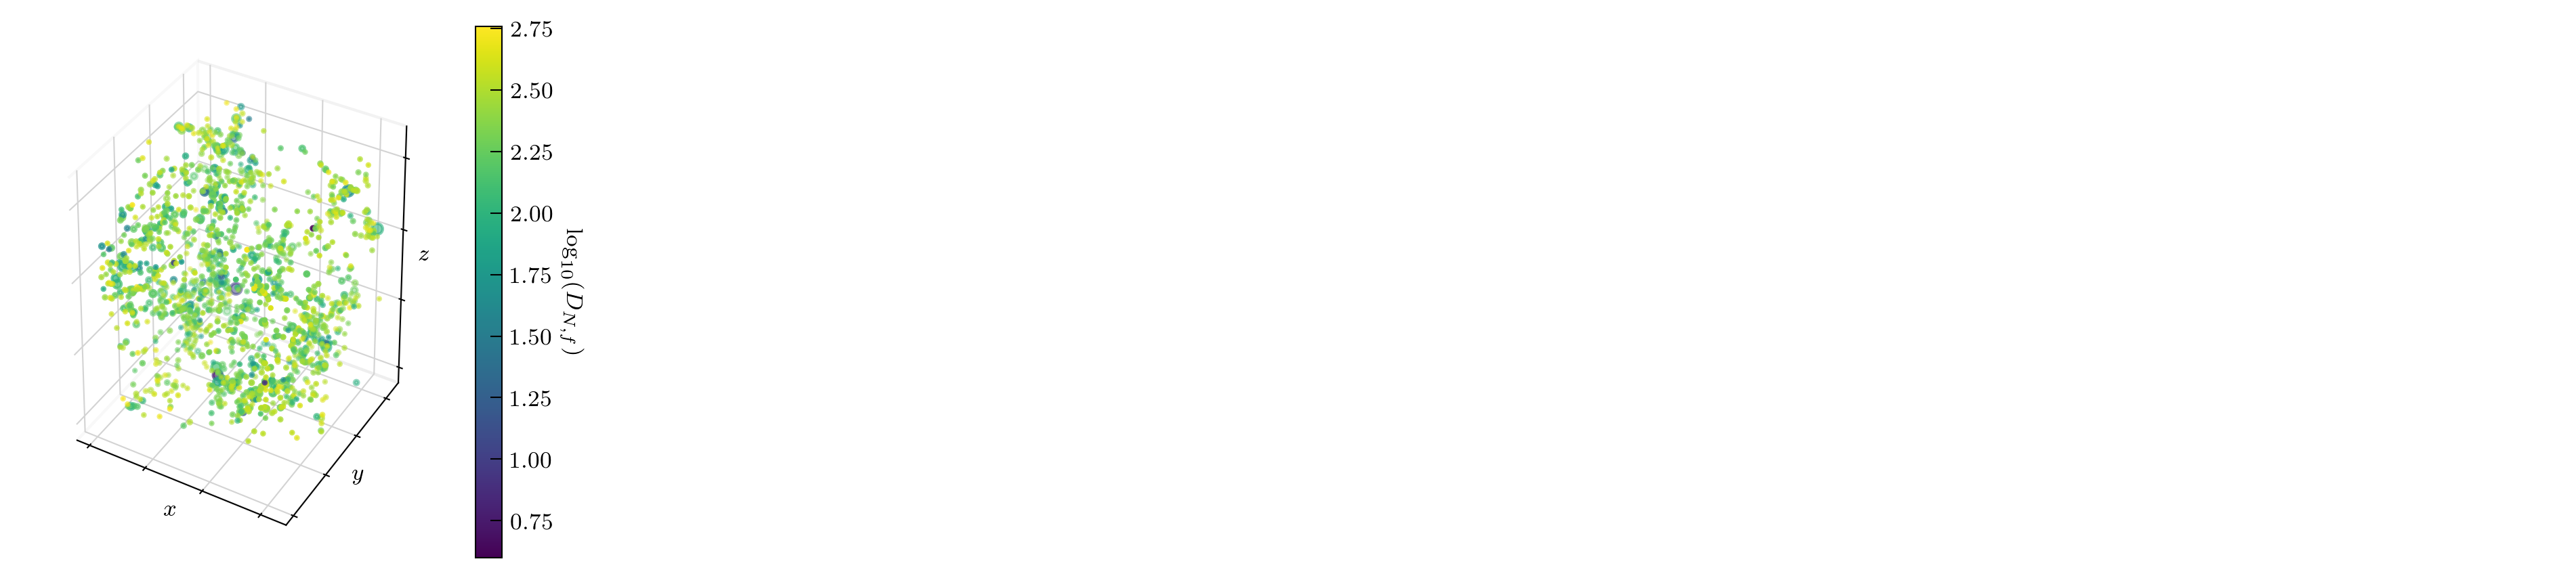

In [12]:
fig, ax = plot3d(
    *haloes['CenterComoving'].T,
    ss=haloes['M200Crit'],
    cs=dnf,
)

# fig.savefig("./plots/3d.pdf")

### Bin splitting

Each log10 mass bin has D_Nf calculated, and is split into two sub-populations: below 25% and above 75%.

In [13]:
d = pd.DataFrame({
    'm': np.log10(1e10*haloes['M200Crit']),
    'd': dnf,
}).iloc[~np.isinf(dnf)]

d['m_bin'] = pd.cut(
    d['m'],
    np.linspace(
        d['m'].min(),
        d['m'].max(), nbins + 1
    ),
    retbins=False,
    labels=np.arange(1, nbins+1)
)

dnf_quantiles = d.groupby('m_bin').quantile([.25, .75])['d']
dnf_quantiles

m_bin      
1      0.25    2.316020
       0.75    2.571634
2      0.25    2.309078
       0.75    2.538493
3      0.25    2.272920
       0.75    2.544238
4      0.25    2.228725
       0.75    2.460584
5      0.25    2.199406
       0.75    2.431016
6      0.25    2.163267
       0.75    2.380298
7      0.25    2.098471
       0.75    2.407333
8      0.25    2.102113
       0.75    2.373521
9      0.25    2.049769
       0.75    2.323544
10     0.25    1.976811
       0.75    2.189092
11     0.25    2.031574
       0.75    2.238792
12     0.25    2.145176
       0.75    2.266566
13     0.25    2.022347
       0.75    2.229379
14     0.25    1.954916
       0.75    2.142123
15     0.25    1.925648
       0.75    2.176552
16     0.25    2.112937
       0.75    2.130726
17     0.25    1.639268
       0.75    2.037347
18     0.25    1.829533
       0.75    2.037605
19     0.25    1.263834
       0.75    1.741306
20     0.25    1.733842
       0.75    1.733842
Name: d, dtype: float64

/cosma/home/dp004/dc-oles1/var/cosma7/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


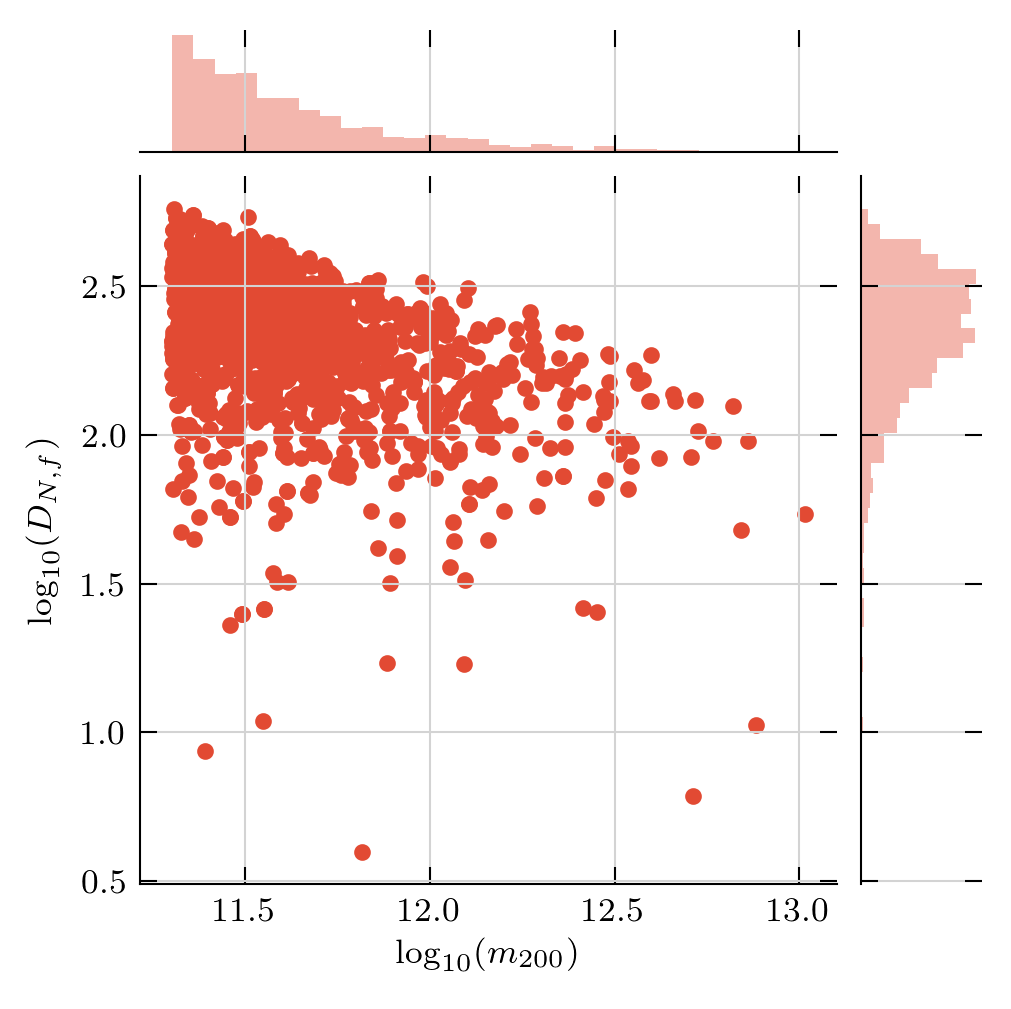

In [14]:
p = sns.jointplot(
    x="m", y="d",
    data=d,
    marker='.',
    stat_func=None,
    height=3.4,
)

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")

# p.savefig("./plots/dnf_all.pdf")

/cosma/home/dp004/dc-oles1/var/cosma7/venv/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


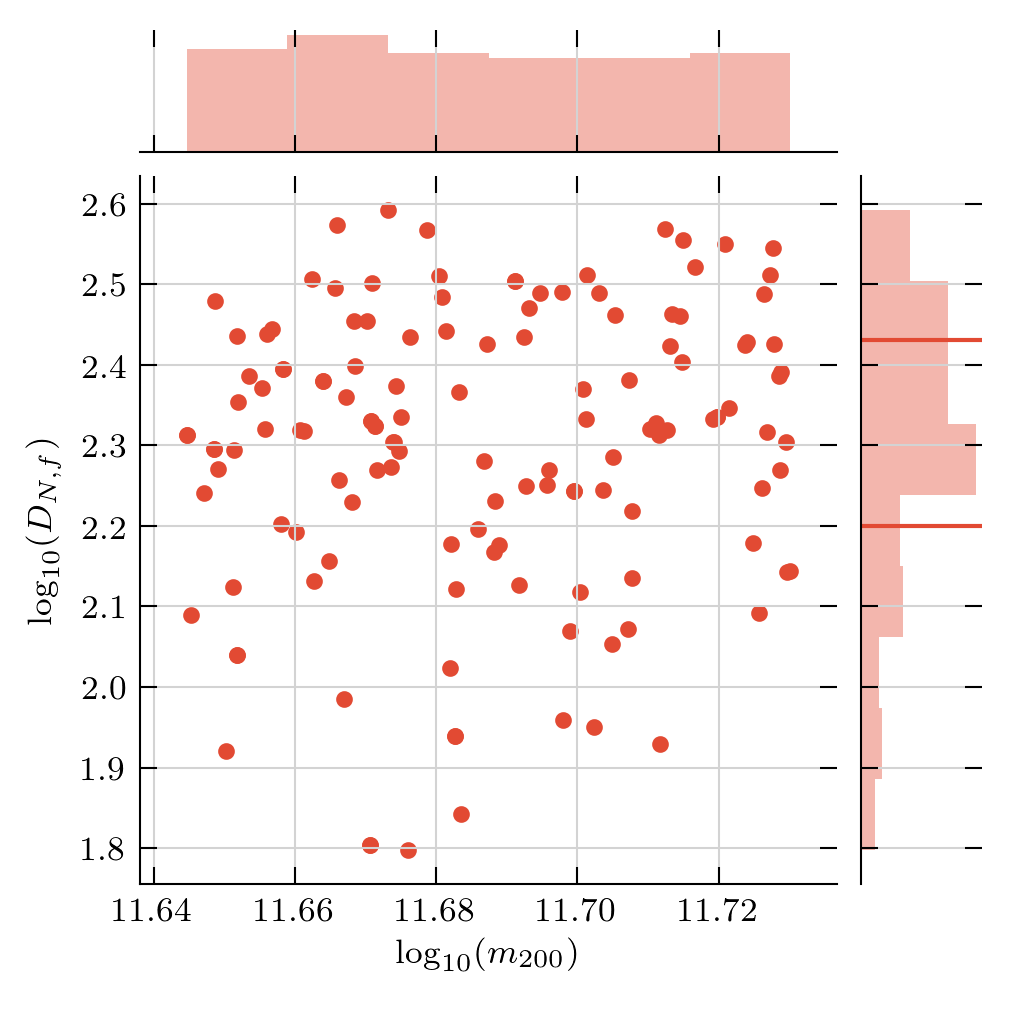

In [15]:
p = sns.jointplot(
    x="m", y="d",
    data=d[d['m_bin'] == bin],
    marker='.',
    stat_func=None,
    height=3.4,
)

plt.axhline(dnf_quantiles.loc[bin].iloc[0])
plt.axhline(dnf_quantiles.loc[bin].iloc[1])

p.set_axis_labels(r"$\log_{10}(m_{200})$", r"$\log_{10}(D_{N,f})$")

# p.savefig("./plots/dnf_bin.pdf")